# House Prices: Data Analysis and Regression Techniques
This dataset includes 79 explanatory variables describing almost every aspect of residential homes in Ames, Iowa. We want to use regression techniques to predict house sale prices.

## Preparation:
### Importing necessary modules

In [109]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lnmd

from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import svm
from sklearn.svm import SVR

import xgboost
from xgboost import plot_importance

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reading datasets

In [3]:
#read datas
test_raw = pd.read_csv('test.csv')
train_raw = pd.read_csv('train.csv')

In [4]:
#Have a look at variables and first five rows
train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#The number of rows and columns of train data
print('Number of rows:',train_raw.shape[0]) 
print('Number of columns:',train_raw.shape[1])

Number of rows: 1460
Number of columns: 81


In [6]:
#Some information of datasets
#train_raw.info()
train_raw.get_dtype_counts()
#descriptive analysis
#train_raw.describe()

float64     3
int64      35
object     43
dtype: int64

We can see that we have 38 numeric variables and 43 categorical variables

## Before analysis:
### Data cleaning

In [7]:
#Duplicate item checking
unique_id = train_raw.Id.nunique()
total_id = train_raw.Id.count()
unique_id == total_id 

True

There is no duplicate id in our dataset.

In [8]:
#we have to process our train_data and test_data at the same way, so we combine two datasets
y = train_raw['SalePrice']
n_train = train_raw.shape[0]
whole_data = pd.concat([train_raw.drop('SalePrice', axis = 1), test_raw]).reset_index(drop=True)

In [9]:
missing_data = whole_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['Name', 'Count missing value']
missing_data['ratio'] = missing_data['Count missing value'] / len(whole_data)
missing_data = missing_data.sort_values('ratio',ascending = False)
missing_data[missing_data['ratio']>0]

,Name,Count missing value,ratio
72,PoolQC,2909,0.996574
74,MiscFeature,2814,0.964029
6,Alley,2721,0.932169
73,Fence,2348,0.804385
57,FireplaceQu,1420,0.486468
3,LotFrontage,486,0.166495
59,GarageYrBlt,159,0.054471
60,GarageFinish,159,0.054471
63,GarageQual,159,0.054471
64,GarageCond,159,0.054471


From the table, we can see that some variables have a large amount of missing values, here we should not conseider these variales as our covariates

In [10]:
whole_data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [11]:
#drop pool quality and utilities, beacause most values are missing in PoolQC, and almost every entry of utilities is the same
whole_data = whole_data.drop(['PoolQC','Utilities'],axis=1)  

In [12]:
#fill missing values
#Now we fill our missing values of categorical variavles with None, fill 0 into missing values of numeric variable.
miss_category = ['MiscFeature', 'Alley', 'Fence', 'FireplaceQu','GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2','BsmtExposure','BsmtQual', 'BsmtCond',  'BsmtFinType1','MSZoning', 'Functional', 'SaleType','KitchenQual',"MasVnrType",'Electrical','Exterior2nd','Exterior1st']
for i in miss_category:
    whole_data[i] = whole_data[i].fillna('None')

miss_numeric = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'GarageCars', 'GarageArea', 'GarageYrBlt']
for i in miss_numeric:
    whole_data[i] = whole_data[i].fillna(0)
    

#fill LotFrontage (linear feet of street connected to property)
whole_data["LotFrontage"] = whole_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


In [13]:
#Change month and year to categorical features, also the condition of the house
whole_data['YrSold'] = whole_data['YrSold'].astype(str)
whole_data['MoSold'] = whole_data['MoSold'].astype(str)
whole_data['OverallCond'] = whole_data['OverallCond'].astype(str)
whole_data['MSSubClass'] = whole_data['MSSubClass'].astype(str)

#Label Encoder for categorical variables with order (such as those that are ranked 1-10)
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

#from sklearn import preprocessing
for i in cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(whole_data[i].values)) 
    whole_data[i] = lbl.transform(list(whole_data[i].values))
    

#Convert categorical variable into dummy/indicator variables.
#whole_data = pd.get_dummies(whole_data)
#whole_data.shape

Now we can get our training data and testing data after processing.

In [14]:
df_train = whole_data[:n_train]
df_train['SalePrice'] = y
df_test = whole_data[n_train:]

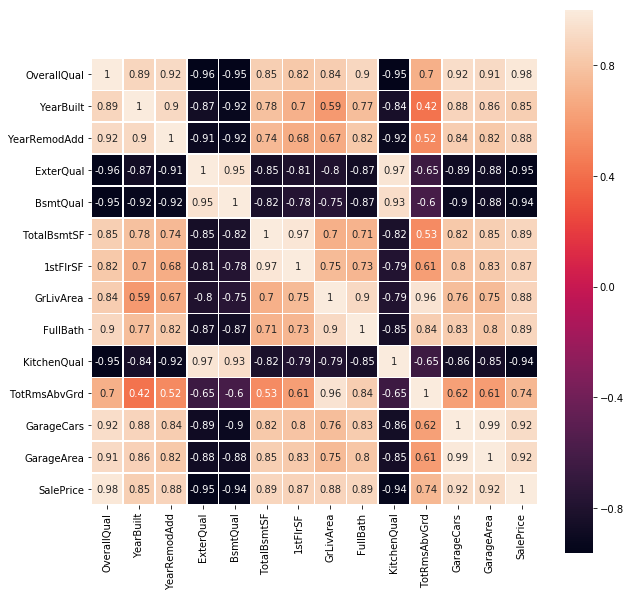

In [15]:
train_corr = df_train.corr()
higher_corr = train_corr.index[abs(train_corr['SalePrice'])>0.5]
train_corr= train_corr[higher_corr].corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(train_corr, square = True, annot = True ,linewidths=.5, ax=ax)

The heatmap shows the correlation between variables which can help us check multicollinearity. We can see some variables are highly correlated and they have similar feature, here we can make some simplification：
- OverallQual (OverallQual & ExterQual & BsmtQual & KtichenQual)
- Garage Cars (Garage Cars & Gareage Area)

## Analysis
#### 1. Sale Price

First of all, let's plot the histogram of Sale Price to see the distribution.

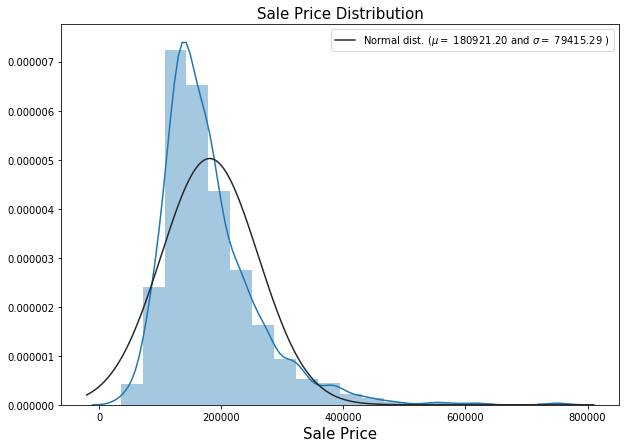

In [16]:
fig, ax1 = plt.subplots(figsize=(10,7))
sns.distplot(df_train['SalePrice'],bins=20,fit=norm)
plt.xlabel('Sale Price', fontsize=15)
plt.title('Sale Price Distribution', fontsize=15)
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

From the distribution plot, we notice that the Sale Price of houses are right skewed, deviated from normal distribution, the mean Sale Price is larger than median of Sale Price. In this situation, log transformation works well for right skewed data.

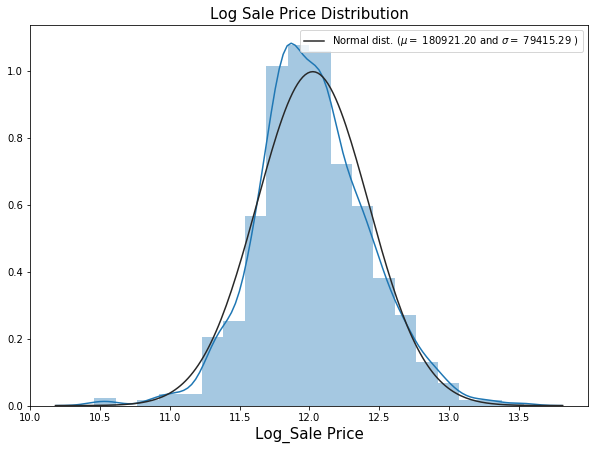

In [17]:
#log transformation
df_train['Log_SalePrice'] = np.log(df_train['SalePrice'])

fig, ax2 = plt.subplots(figsize=(10,7))
sns.distplot(df_train['Log_SalePrice'], fit=norm, bins=20)
plt.xlabel('Log_Sale Price', fontsize=15)
plt.title('Log Sale Price Distribution', fontsize=15)
(mu_l, sigma_l) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_l, sigma_l)],
            loc='best')


#### 2. Overall Quality 

Text(0.5,1,'Sale Price by Overall Quality')

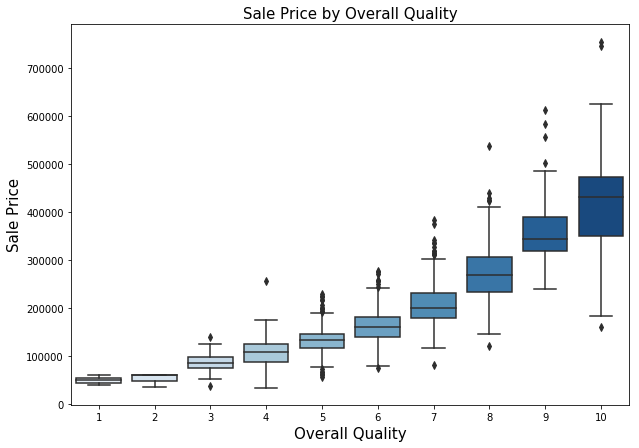

In [18]:
fig, ax3 = plt.subplots(figsize=(10,7))
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df_train, palette="Blues")
plt.xlabel('Overall Quality', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price by Overall Quality', fontsize = 15)

From correlation heatmap, we can see that OverallQual is highly correlated to Sale Price of houses. From the boxplot:
- It's very obvious that Sale Price increases with the increasing of Overall Quality
- For quality level from 4 to 7, the variances of Sale Price are larger

It's reasonable that Overall Quality is positively correlated to Sale Price. For middle level qualities housing, people usually take other factors into account which effect the Sale Price a lot.

#### 3. Living Area

Text(0.5,1,'Sale Price by Living Area')

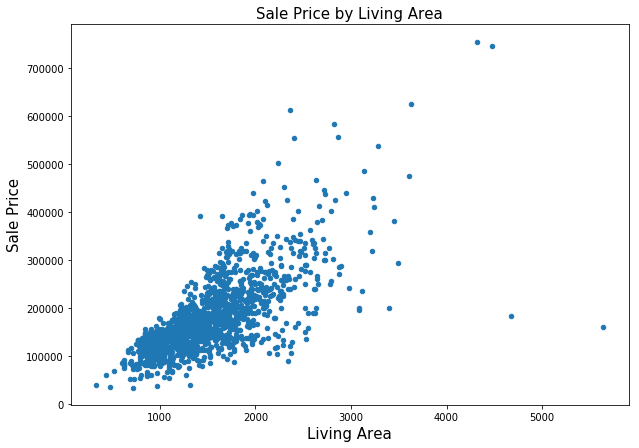

In [19]:
df_train.plot.scatter(x = 'GrLivArea', y = 'SalePrice',figsize=(10,7))
plt.xlabel('Living Area', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price by Living Area', fontsize = 15)

There are two points with large Living Area but low Sale Price which not follow the pattern, we can define them as outliers and remove them.

Text(0.5,1,'Sale Price by Living Area')

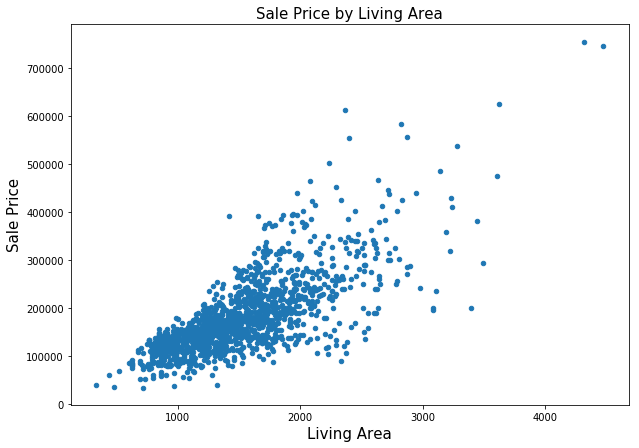

In [20]:
#some outliers (huge living area but low sale price)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train.plot.scatter(x = 'GrLivArea', y = 'SalePrice',figsize=(10,7))
plt.xlabel('Living Area', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price by Living Area', fontsize = 15)

#### 4. Garage Cars

Text(0.5,1,'Sale Price by Garage Cars')

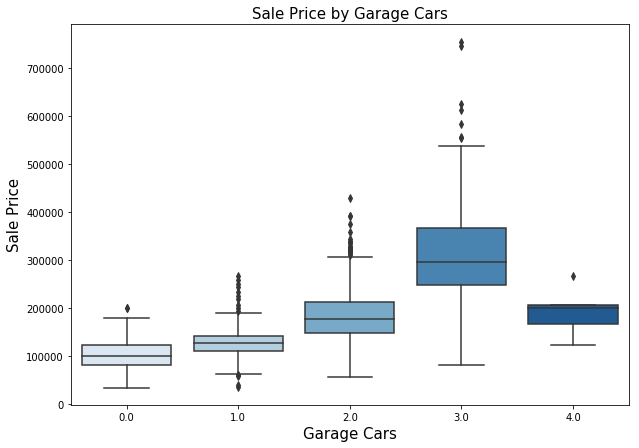

In [21]:
#Garage Cars (garage cars and garage area are highly correlated)
fig, ax4 = plt.subplots(figsize=(10,7))
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = df_train, palette="Blues")
plt.xlabel('Garage Cars', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price by Garage Cars', fontsize = 15)


We can notice that houses with 3 garage cars have the highest average sale price, and houses at very high price usually have 3 garage cars.

## Model

In [22]:
#from sklearn import preprocessing
x_col = ['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
x = df_train[x_col]
y = df_train['Log_SalePrice']

Seperate train data to training set and validation set.

In [68]:
#from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=42)
train_data = pd.concat([x_train, y_train], axis =1)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,Log_SalePrice
616,6,2002,783.0,1509,2,7,2.0,12.118334
614,4,1972,630.0,630,1,3,0.0,11.231888
1303,7,2005,1616.0,1616,2,7,3.0,12.354493
486,5,1965,1073.0,1073,1,6,2.0,11.957611
562,5,1940,996.0,996,1,6,0.0,11.589887


#### 1. Linear Regression

In [69]:
#import statsmodels.formula.api as smf

lm = smf.ols(formula = "Log_SalePrice ~ OverallQual + YearBuilt + TotalBsmtSF +  GrLivArea + FullBath + TotRmsAbvGrd + GarageCars", data = train_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Log_SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     804.8
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:01:10   Log-Likelihood:                 443.36
No. Observations:                 976   AIC:                            -870.7
Df Residuals:                     968   BIC:                            -831.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.6023      0.448     12.510      0.000       4.723       6.481
OverallQual      0.0905      0.006     15.868      0.000       0.079       0.102
YearBuilt        0.0026      0.000     11.088      0.000       0.002       0.003
TotalBsmtSF      0.0002   1.46e-05     12.786      0.000       0.000       0.000
GrLivArea        0.0003   2.18e-05     14.751      0.000       0.000       0.000
FullBath        -0.0292      0.013     -2.232      0.026      -0.055      -0.004
TotRmsAbvGrd    -0.0054      0.006     -0.958      0.338      -0.016       0.006
GarageCars       0.0762      0.009      8.357      0.000       0.058       0.094
==============================================================================
Omnibus:                      165.943   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              552.945
Skew:                          -0.810   Prob(JB):                    8.50e-121
Kurtosis:                       6.312   Cond. No.                     2.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The R-square of linear model is 0.853, most coefficients are significant.
- The p-value of Total Rooms above Ground  is larger than 0.05 which means this predictor is not significant. 
- The coefficient of Total Rooms above Ground and Full Bath are negative. It's not reasonable that the number of rooms has a negative impact on house sale price, we need to check multicollinearity between these varibales and use recursive feature elimination method to select predictors.

In [78]:
lm_fitted = lm.fittedvalues
pred_lm = lm.predict(x_valid)

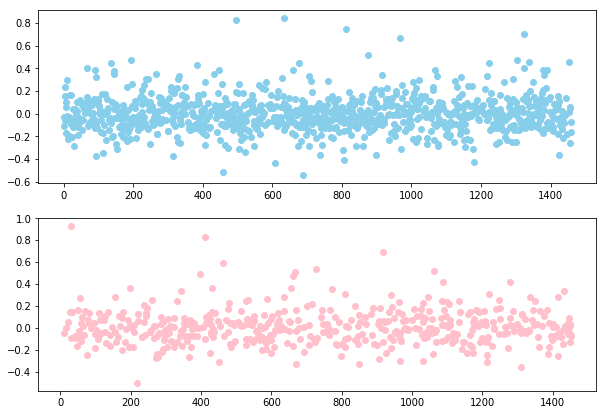

In [79]:
fig, ax5 = plt.subplots(2,1,figsize=(10,7))
ax5[0].plot((lm_fitted - y_train),'bo',color = 'skyblue', )
ax5[1].plot((pred_lm - y_valid),'bo', color = 'pink')

Text(0.5,1,'Distribution Plot of residual(Validation Set)')

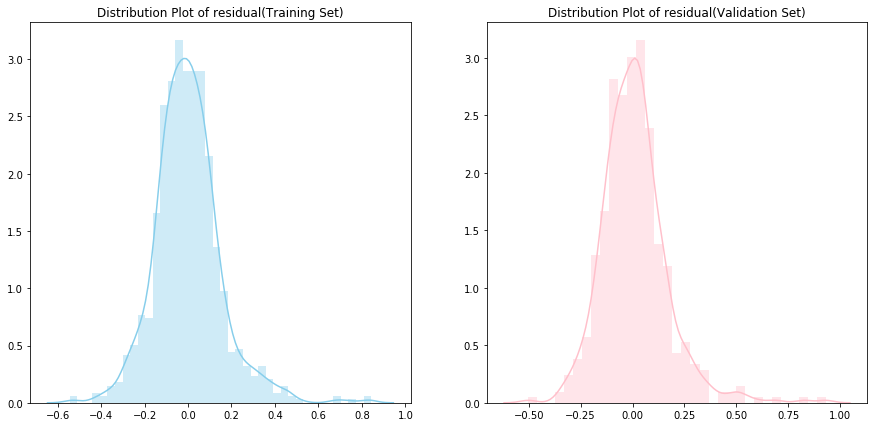

In [91]:
fig, ax6 = plt.subplots(1,2,figsize=(15,7))
sns.distplot((lm_fitted - y_train), color = 'skyblue', ax=ax6[0])
ax6[0].set_title('Distribution Plot of residual(Training Set)')
sns.distplot((pred_lm - y_valid), color = 'pink', ax=ax6[1])
ax6[1].set_title('Distribution Plot of residual(Validation Set)')

In [92]:
#Root mean squared error
#from sklearn import metrics
mse_lm = metrics.mean_squared_error(pred_lm,y_valid)
rmse_lm = np.sqrt(mse_lm)
print('Linear Regression Model' + " RMSE:" + str(rmse_lm))

Linear Regression Model RMSE:0.15955658187073343


#### 2. Linear Regression with Lasso

In [97]:
#from sklearn import linear_model as lnmd
lasso_lm = lnmd.Lasso().fit(x_train, y_train)
pred_lasso =lasso_lm.predict(x_valid)

In [98]:
#Root mean squared error
mse_lasso = metrics.mean_squared_error(pred_lasso,y_valid)
rmse_lasso = np.sqrt(mse_lasso)
print('Linear Regression Model with Lasso' + " RMSE:" + str(rmse_lasso))

Linear Regression Model with Lasso RMSE:0.19293985588977508


#### 3. SVR

In [99]:
#Support Vector Regression (svm when the inputs are continous variables)
#from sklearn import svm
SVR_model = svm.SVR().fit(x_train, y_train)
pred_SVR =SVR_model.predict(x_valid)
mse_SVR = metrics.mean_squared_error(pred_SVR,y_valid)
rmse_SVR = np.sqrt(mse_SVR)
print('Linear Regression Model with Lasso' + " RMSE:" + str(rmse_SVR))


Linear Regression Model with Lasso RMSE:0.3812598370155988


#### 4. Xgboost Model

In [111]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xgb_model.fit(x_train, y_train)
pred_xgb = xgb_model.predict(x_valid)
mse_xgb = metrics.mean_squared_error(pred_xgb,y_valid)
rmse_xgb = np.sqrt(mse_xgb)
print('Xgboost Model' + " RMSE:" + str(rmse_xgb))

[22:02:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost Model RMSE:0.16867081956149016


Finally, we choose linear regression model as our final predicting model

## Prediction

In [112]:
x_col = ['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
x_test = df_test[x_col]
y_test = lm.predict(x_test)

In [116]:
price_test = np.exp(y_test)
price_test.head()

1460    113373.294774
1461    153078.574766
1462    165746.364304
1463    179436.863892
1464    206044.377852
dtype: float64

In [121]:
price_test.describe()

count    1.459000e+03
mean     1.793410e+05
std      8.627542e+04
min      6.066404e+04
25%      1.253088e+05
50%      1.582105e+05
75%      2.103915e+05
max      1.834211e+06
dtype: float64

In [120]:
df_train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64